# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional


In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
print("Training Data Overview:")
print(train.head())


In [ ]:
pm25_stats = train['pm2.5'].describe()
print(pm25_stats)

# If you want mean, std, min, max separately
pm25_mean = train['pm2.5'].mean()
pm25_std = train['pm2.5'].std()
pm25_min = train['pm2.5'].min()
pm25_max = train['pm2.5'].max()

print(f"Mean: {pm25_mean}, Std: {pm25_std}, Min: {pm25_min}, Max: {pm25_max}")

In [ ]:
train.columns

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv("data/train.csv", parse_dates=['datetime'])
train.set_index('datetime', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(train['pm2.5'], color='blue')
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Datetime')
plt.ylabel('PM2.5 (µg/m³)')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(train['pm2.5'], bins=50, kde=True, color='green')
plt.title('Distribution of PM2.5 Values')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=train['pm2.5'], color='orange')
plt.title('Boxplot of PM2.5 Values')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()

train['hour'] = train.index.hour
hourly_avg = train.groupby('hour')['pm2.5'].mean()

plt.figure(figsize=(10,5))
plt.plot(hourly_avg, marker='o')
plt.title('Average PM2.5 by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average PM2.5')
plt.grid(True)
plt.show()

train['day_of_week'] = train.index.dayofweek
weekly_avg = train.groupby('day_of_week')['pm2.5'].mean()

plt.figure(figsize=(10,5))
plt.plot(weekly_avg, marker='o', color='purple')
plt.title('Average PM2.5 by Day of Week (0=Monday)')
plt.xlabel('Day of Week')
plt.ylabel('Average PM2.5')
plt.grid(True)
plt.show()


In [ ]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Store original data for later use
X_original = train.drop(['pm2.5', 'No'], axis=1)
y_original = train['pm2.5'].values


In [ ]:
X_train_basic = train.drop(['pm2.5', 'No'], axis=1)
y_train_basic = train['pm2.5']

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
scaler_basic = MinMaxScaler()
X_train_scaled_basic = scaler_basic.fit_transform(X_train_basic)

In [ ]:
X_train_lstm_basic = np.expand_dims(X_train_scaled_basic, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
model_basic = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train_lstm_basic.shape[1], X_train_lstm_basic.shape[2])),
    Dense(1)
])

model_basic.compile(optimizer='adam', loss='mse')
model_basic.summary()

In [ ]:
history_basic = model_basic.fit(
    X_train_lstm_basic, y_train_basic,
    epochs=10,
    batch_size=32,
    verbose=1  # Changed from 0 to see progress
)

train_pred_basic = model_basic.predict(X_train_lstm_basic, verbose=0)
basic_rmse = np.sqrt(mean_squared_error(y_train_basic, train_pred_basic))
print(f"Basic Model Training RMSE: {basic_rmse:.2f}")

# Initialize results dictionary
rmse_results = {'Step1_Basic': basic_rmse}

In [ ]:
split_idx = int(len(train) * 0.8)
train_data = train.iloc[:split_idx]
val_data = train.iloc[split_idx:]

X_train_step2 = train_data.drop(['pm2.5', 'No'], axis=1)
y_train_step2 = train_data['pm2.5']
X_val_step2 = val_data.drop(['pm2.5', 'No'], axis=1)
y_val_step2 = val_data['pm2.5']


# Scale using training data only
scaler_step2 = MinMaxScaler()
X_train_scaled_step2 = scaler_step2.fit_transform(X_train_step2)
X_val_scaled_step2 = scaler_step2.transform(X_val_step2)

In [ ]:
X_train_lstm_step2 = np.expand_dims(X_train_scaled_step2, axis=1)
X_val_lstm_step2 = np.expand_dims(X_val_scaled_step2, axis=1)

# Same model architecture
model_step2 = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train_lstm_step2.shape[1], X_train_lstm_step2.shape[2])),
    Dense(1)
])
model_step2.compile(optimizer='adam', loss='mse')

# Train with validation
print("Training with validation split...")
history_step2 = model_step2.fit(
    X_train_lstm_step2, y_train_step2,
    validation_data=(X_val_lstm_step2, y_val_step2),
    epochs=20,
    batch_size=32,
    verbose=1
)

In [ ]:
train_pred_step2 = model_step2.predict(X_train_lstm_step2, verbose=0)
val_pred_step2 = model_step2.predict(X_val_lstm_step2, verbose=0)

train_rmse_step2 = np.sqrt(mean_squared_error(y_train_step2, train_pred_step2))
val_rmse_step2 = np.sqrt(mean_squared_error(y_val_step2, val_pred_step2))

rmse_results['Step2_Validation'] = val_rmse_step2

print(f"Step 2 - Train RMSE: {train_rmse_step2:.2f}")
print(f"Step 2 - Validation RMSE: {val_rmse_step2:.2f}")

In [ ]:
def add_lag_features(df, target_col='pm2.5', lags=[1, 2, 3]):
    df = df.copy()
    if target_col in df.columns:
        for lag in lags:
            df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Apply lag features to train data
train_with_lags = add_lag_features(train)

# Split again with lag features
split_idx_step3 = int(len(train_with_lags) * 0.8)
train_data_step3 = train_with_lags.iloc[:split_idx_step3]
val_data_step3 = train_with_lags.iloc[split_idx_step3:]

X_train_step3 = train_data_step3.drop(['pm2.5', 'No'], axis=1)
y_train_step3 = train_data_step3['pm2.5']
X_val_step3 = val_data_step3.drop(['pm2.5', 'No'], axis=1)
y_val_step3 = val_data_step3['pm2.5']

# Scale
scaler_step3 = MinMaxScaler()
X_train_scaled_step3 = scaler_step3.fit_transform(X_train_step3)
X_val_scaled_step3 = scaler_step3.transform(X_val_step3)

# Reshape for LSTM
X_train_lstm_step3 = np.expand_dims(X_train_scaled_step3, axis=1)
X_val_lstm_step3 = np.expand_dims(X_val_scaled_step3, axis=1)

# Same model architecture
model_step3 = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train_lstm_step3.shape[1], X_train_lstm_step3.shape[2])),
    Dense(1)
])
model_step3.compile(optimizer='adam', loss='mse')

print("Training with lag features...")
history_step3 = model_step3.fit(
    X_train_lstm_step3, y_train_step3,
    validation_data=(X_val_lstm_step3, y_val_step3),
    epochs=20,
    batch_size=32,
    verbose=0
)

# Evaluate
val_pred_step3 = model_step3.predict(X_val_lstm_step3, verbose=0)
val_rmse_step3 = np.sqrt(mean_squared_error(y_val_step3, val_pred_step3))
print(f"Step 3 - Validation RMSE with lags: {val_rmse_step3:.2f}")


In [ ]:
# Better model with dropout
model_step4 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm_step3.shape[1], X_train_lstm_step3.shape[2]), 
         return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model_step4.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Training improved model...")
history_step4 = model_step4.fit(
    X_train_lstm_step3, y_train_step3,
    validation_data=(X_val_lstm_step3, y_val_step3),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

val_pred_step4 = model_step4.predict(X_val_lstm_step3, verbose=0)
val_rmse_step4 = np.sqrt(mean_squared_error(y_val_step3, val_pred_step4))
print(f"Step 4 - Validation RMSE with better model: {val_rmse_step4:.2f}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
seq_length = 48
batch_size = 32
epochs = 50

# Timeseries Generators (reuse your existing scaled data)
train_gen = TimeseriesGenerator(X_train_seq, y_train_seq, length=seq_length, batch_size=batch_size)
val_gen = TimeseriesGenerator(X_val_seq, y_val_seq, length=seq_length, batch_size=batch_size)

# Hybrid BiLSTM + GRU Model
model_step5_hybrid = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(seq_length, X_train_seq.shape[1])),
    Dropout(0.3),
    GRU(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(1)
])

model_step5_hybrid.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_step5_hybrid.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history_step5_hybrid = model_step5_hybrid.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=1
)

# Validation predictions
val_preds_scaled = model_step5_hybrid.predict(val_gen)
val_preds = scaler_y.inverse_transform(val_preds_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq[seq_length:])

val_rmse_step5_hybrid = np.sqrt(mean_squared_error(y_val_true, val_preds))
rmse_results['Step5_Hybrid_BiLSTM_GRU'] = val_rmse_step5_hybrid
print(f"Step 5 Hybrid BiLSTM+GRU - Validation RMSE: {val_rmse_step5_hybrid:.2f}")


In [ ]:
# Display all results
print("="*50)
print("FINAL RESULTS COMPARISON")
print("="*50)
for step, rmse in rmse_results.items():
    print(f"{step}: RMSE = {rmse:.2f}")

# Plot comparison
plt.figure(figsize=(12, 6))
steps = list(rmse_results.keys())
rmse_values = list(rmse_results.values())

# Clean step names
clean_steps = [s.replace('Step', 'Step ').replace('_', ' ') for s in steps]

bars = plt.bar(clean_steps, rmse_values, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.title('RMSE Improvement Through Steps')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Add value labels
for i, (bar, v) in enumerate(zip(bars, rmse_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

improvement = ((rmse_results['Step1_Basic'] - rmse_results['Step5_Sequences'])/rmse_results['Step1_Basic'])*100
print(f"\nTotal improvement: {improvement:.1f}%")

Generating test predictions...


/Users/darylmurenzi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/darylmurenzi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Test predictions - Min: -0.35, Max: 352.48
Submission saved! Shape: (13148, 2)


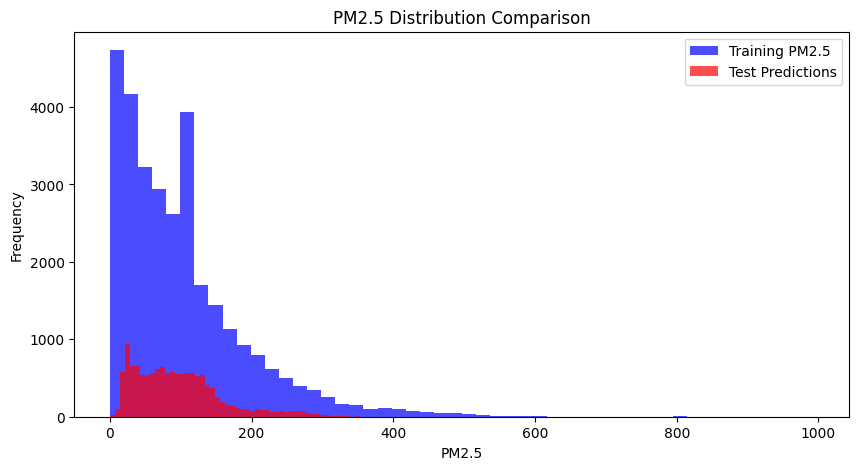

Test predictions completed successfully!


In [50]:
print("Generating test predictions...")

# Prepare test data (use Step 5 scalers and model)
test_features = test.drop(['No'], axis=1, errors='ignore')

# Handle missing columns
missing_cols = []
for col in X_original.columns:
    if col not in test_features.columns:
        test_features[col] = 0
        missing_cols.append(col)

if missing_cols:
    print(f"Added missing columns: {missing_cols}")

# Ensure same column order
test_features = test_features[X_original.columns]
test_scaled = scaler_X.transform(test_features)

# Combine training tail + test for sequences
train_tail = X_scaled[-seq_length:]
combined = np.vstack([train_tail, test_scaled])

# Create test generator
test_gen = TimeseriesGenerator(combined, np.zeros(len(combined)), length=seq_length, batch_size=32)

# Predict
test_preds_scaled = model_step5.predict(test_gen, verbose=1)
test_preds = scaler_y.inverse_transform(test_preds_scaled)

print(f"Test predictions - Min: {test_preds.min():.2f}, Max: {test_preds.max():.2f}")

# Create submission
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_preds.flatten()
})

submission.to_csv('data/final_submission.csv', index=False)
print(f"Submission saved! Shape: {submission.shape}")

# Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(y_original, bins=50, alpha=0.7, label='Training PM2.5', color='blue')
plt.hist(test_preds.flatten(), bins=50, alpha=0.7, label='Test Predictions', color='red')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.title('PM2.5 Distribution Comparison')
plt.legend()
plt.show()

print("Test predictions completed successfully!")